<a href="https://colab.research.google.com/github/HarshalRaut16/deep_learning_evaluation/blob/main/Task_2_Plastic_Bottles_or_Metal_Bottles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Mar 23 05:43:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [75]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers


import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub
import pathlib
import numpy as np
import random
import datetime

In [4]:
#Unzip the downloaded file
zip_ref = zipfile.ZipFile("plastic_and_metal_bottles.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
!ls

drive  plastic_and_metal_bottles  plastic_and_metal_bottles.zip  sample_data


In [6]:
!ls plastic_and_metal_bottles/Train_data

'Metal Bottle'	'Plastic Bottle'


In [7]:
# Walk through plastic_and_metal_bottles directory and list number of files
for dirpath, dirnames, filenames in os.walk("plastic_and_metal_bottles"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'plastic_and_metal_bottles'.
There are 2 directories and 0 images in 'plastic_and_metal_bottles/Train_data'.
There are 0 directories and 420 images in 'plastic_and_metal_bottles/Train_data/Metal Bottle'.
There are 0 directories and 420 images in 'plastic_and_metal_bottles/Train_data/Plastic Bottle'.
There are 2 directories and 0 images in 'plastic_and_metal_bottles/Test_data'.
There are 0 directories and 180 images in 'plastic_and_metal_bottles/Test_data/Metal Bottle'.
There are 0 directories and 180 images in 'plastic_and_metal_bottles/Test_data/Plastic Bottle'.


In [76]:
data_dir = pathlib.Path("plastic_and_metal_bottles/Train_data/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Metal Bottle' 'Plastic Bottle']


In [8]:
# View an image

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [31]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

Image shape: (879, 558, 3)


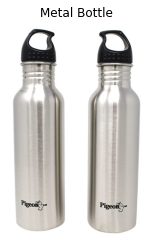

In [9]:
# View a random image from the training dataset
img = view_random_image(target_dir="plastic_and_metal_bottles/Train_data/",
                        target_class="Metal Bottle")

In [10]:
# View the img 
img

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [11]:
# View the image shape
img.shape # returns (width, height, colour channels)

(879, 558, 3)

In [12]:
# Get all the pixel values between 0 & 1
img/255.

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

# Setting up callbacks

In [13]:
# Create tensorboard callback (functionized because need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Create Base Model

In [14]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "plastic_and_metal_bottles/Train_data/"
test_dir = "plastic_and_metal_bottles/Test_data/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="Base Model")])

Found 840 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Saving TensorBoard log files to: tensorflow_hub_1/Base Model/20230323-060437
Epoch 1/5
27/27 [==============================] - 34s 834ms/step - loss: 0.6825 - accuracy: 0.5548 - val_loss: 0.6715 - val_accuracy: 0.6000
Epoch 2/5
27/27 [==============================] - 19s 688ms/step - loss: 0.6206 - accuracy: 0.6524 - val_loss: 0.6139 - val_accuracy: 0.6750
Epoch 3/5
27/27 [==============================] - 20s 746ms/step - loss: 0.5553 - accuracy: 0.7202 - val_loss: 0.5960 - val_accuracy: 0.6833
Epoch 4/5
27/27 [==============================] - 19s 698ms/step - loss: 0.5046 - accuracy: 0.7690 - val_loss: 0.5854 - val_accuracy: 0.7167
Epoch 5/5
27/27 [==============================] - 18s 694ms/step - loss: 0.4459 - accuracy: 0.8036 - val_loss: 0.5613 - val_accuracy: 0.7250


In [15]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

# model 2

In [16]:
# model 2
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="Model 2")])

Saving TensorBoard log files to: tensorflow_hub_1/Model 2/20230323-060805
Epoch 1/5
27/27 [==============================] - 22s 698ms/step - loss: 0.6934 - accuracy: 0.4952 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
27/27 [==============================] - 22s 821ms/step - loss: 0.6924 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
27/27 [==============================] - 22s 817ms/step - loss: 0.6923 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
27/27 [==============================] - 20s 743ms/step - loss: 0.6924 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
27/27 [==============================] - 18s 684ms/step - loss: 0.6923 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5000


In [17]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


# Model 3

In [18]:
# Increate neurons
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="model 3")])

Saving TensorBoard log files to: tensorflow_hub_1/model 3/20230323-061018
Epoch 1/5
27/27 [==============================] - 20s 690ms/step - loss: 9.7125 - accuracy: 0.5298 - val_loss: 1.6404 - val_accuracy: 0.5833
Epoch 2/5
27/27 [==============================] - 22s 813ms/step - loss: 3.9632 - accuracy: 0.5036 - val_loss: 1.2132 - val_accuracy: 0.6222
Epoch 3/5
27/27 [==============================] - 18s 684ms/step - loss: 1.2804 - accuracy: 0.6107 - val_loss: 1.1431 - val_accuracy: 0.5028
Epoch 4/5
27/27 [==============================] - 19s 701ms/step - loss: 1.5568 - accuracy: 0.5679 - val_loss: 1.4169 - val_accuracy: 0.5361
Epoch 5/5
27/27 [==============================] - 18s 689ms/step - loss: 0.8847 - accuracy: 0.6167 - val_loss: 0.9618 - val_accuracy: 0.5389


In [19]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


Image shape: (1500, 1170, 3)
Image shape: (612, 226, 3)


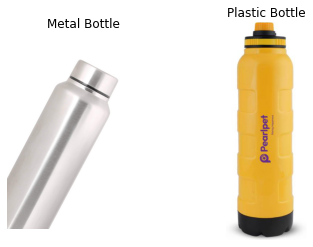

In [20]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
metal_bottle_img = view_random_image("plastic_and_metal_bottles/Train_data/", "Metal Bottle")
plt.subplot(1, 2, 2)
plastic_bottle_img = view_random_image("plastic_and_metal_bottles/Train_data/", "Plastic Bottle")

### Preprocess the data (prepare it for a model)


In [21]:
# Define training and test directory paths
train_dir = "plastic_and_metal_bottles/Train_data/"
test_dir = "plastic_and_metal_bottles/Test_data/"

In [22]:
# Create train and test data generators and rescale the data 
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [23]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 840 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


In [24]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [25]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          ...,
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ]],
 
         [[0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          ...,
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ]],
 
         [[0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          [0.85098046, 0.85098046, 0.8196079 ],
          ...,
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ],
          [0.8862746 , 0.89019614, 0.8705883 ]],
 
         ...,
 
         [[0.8196079 , 0.8196079 , 0.7725491 ],
          [0.82745

In [26]:
# View the first batch of labels
labels

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

# Model 4

In [27]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

In [28]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [29]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(27, 12)

In [30]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="model 4")])

Saving TensorBoard log files to: tensorflow_hub_1/model 4/20230323-061335
Epoch 1/5
27/27 [==============================] - 26s 914ms/step - loss: 2.8185 - accuracy: 0.5405 - val_loss: 0.6483 - val_accuracy: 0.6278
Epoch 2/5
27/27 [==============================] - 23s 846ms/step - loss: 0.5058 - accuracy: 0.7702 - val_loss: 0.6019 - val_accuracy: 0.7000
Epoch 3/5
27/27 [==============================] - 18s 678ms/step - loss: 0.2943 - accuracy: 0.8857 - val_loss: 0.6941 - val_accuracy: 0.6917
Epoch 4/5
27/27 [==============================] - 20s 744ms/step - loss: 0.1843 - accuracy: 0.9417 - val_loss: 0.8683 - val_accuracy: 0.6556
Epoch 5/5
27/27 [==============================] - 19s 702ms/step - loss: 0.1411 - accuracy: 0.9583 - val_loss: 0.7543 - val_accuracy: 0.6667


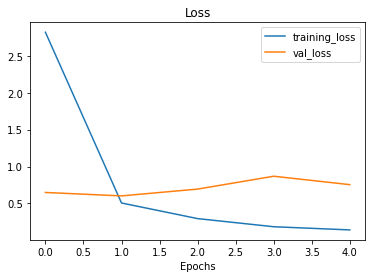

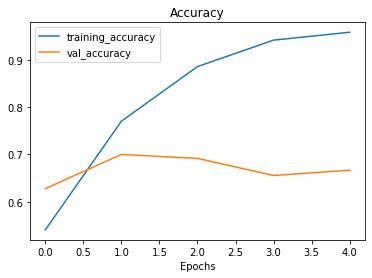

In [32]:
# Plot loss curves of model_5 results
plot_loss_curves(history_4)

# Model 5

In [33]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

In [34]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [35]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="model 5")])

Saving TensorBoard log files to: tensorflow_hub_1/model 5/20230323-061749
Epoch 1/5
27/27 [==============================] - 22s 764ms/step - loss: 0.6725 - accuracy: 0.5940 - val_loss: 0.6605 - val_accuracy: 0.6083
Epoch 2/5
27/27 [==============================] - 18s 694ms/step - loss: 0.6255 - accuracy: 0.6440 - val_loss: 0.6161 - val_accuracy: 0.6639
Epoch 3/5
27/27 [==============================] - 22s 827ms/step - loss: 0.5649 - accuracy: 0.7190 - val_loss: 0.6404 - val_accuracy: 0.6333
Epoch 4/5
27/27 [==============================] - 18s 694ms/step - loss: 0.5588 - accuracy: 0.7310 - val_loss: 0.5946 - val_accuracy: 0.7028
Epoch 5/5
27/27 [==============================] - 22s 820ms/step - loss: 0.4804 - accuracy: 0.7762 - val_loss: 0.6378 - val_accuracy: 0.6556


In [36]:
# Check out the model architecture
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

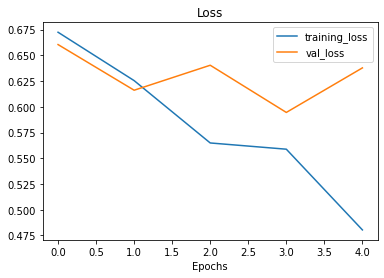

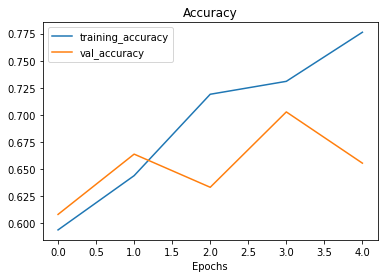

In [37]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

# Data Augmentation 
- to increase size of data

In [38]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [39]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images:
Found 840 images belonging to 2 classes.
Non-augmented training images:
Found 840 images belonging to 2 classes.
Unchanged test images:
Found 360 images belonging to 2 classes.


In [40]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

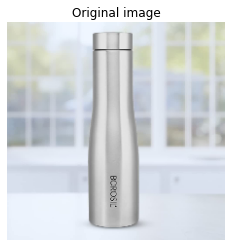

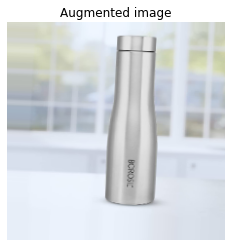

In [41]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

# Model 6

In [42]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="model 6")])

Saving TensorBoard log files to: tensorflow_hub_1/model 6/20230323-062041
Epoch 1/5
27/27 [==============================] - 33s 1s/step - loss: 0.7199 - accuracy: 0.4881 - val_loss: 0.6910 - val_accuracy: 0.5500
Epoch 2/5
27/27 [==============================] - 29s 1s/step - loss: 0.6968 - accuracy: 0.4345 - val_loss: 0.6877 - val_accuracy: 0.6111
Epoch 3/5
27/27 [==============================] - 27s 989ms/step - loss: 0.6939 - accuracy: 0.5036 - val_loss: 0.6816 - val_accuracy: 0.5472
Epoch 4/5
27/27 [==============================] - 27s 975ms/step - loss: 0.6868 - accuracy: 0.5655 - val_loss: 0.6672 - val_accuracy: 0.6861
Epoch 5/5
27/27 [==============================] - 27s 998ms/step - loss: 0.6839 - accuracy: 0.5750 - val_loss: 0.6622 - val_accuracy: 0.6167


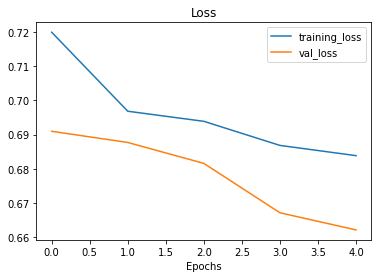

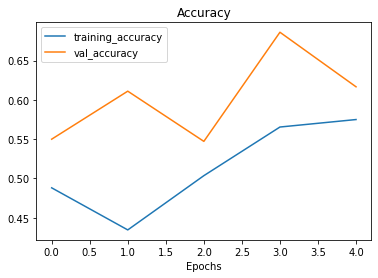

In [43]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

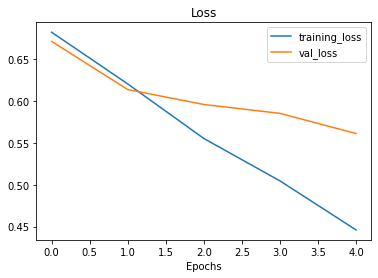

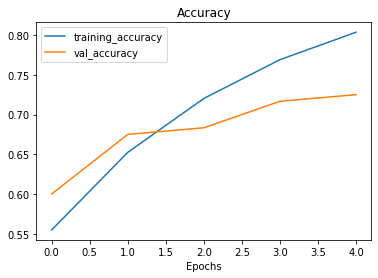

In [44]:
plot_loss_curves(history_1)

In [45]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 840 images belonging to 2 classes.


In [46]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs here
                                                                         experiment_name="model 7")])

Saving TensorBoard log files to: tensorflow_hub_1/model 7/20230323-062409
Epoch 1/5
27/27 [==============================] - 33s 1s/step - loss: 0.6970 - accuracy: 0.4917 - val_loss: 0.6907 - val_accuracy: 0.5583
Epoch 2/5
27/27 [==============================] - 27s 999ms/step - loss: 0.6927 - accuracy: 0.5274 - val_loss: 0.6873 - val_accuracy: 0.4972
Epoch 3/5
27/27 [==============================] - 27s 1s/step - loss: 0.6781 - accuracy: 0.5512 - val_loss: 0.6414 - val_accuracy: 0.6444
Epoch 4/5
27/27 [==============================] - 27s 1s/step - loss: 0.6601 - accuracy: 0.5857 - val_loss: 0.6483 - val_accuracy: 0.5694
Epoch 5/5
27/27 [==============================] - 27s 1s/step - loss: 0.6239 - accuracy: 0.6702 - val_loss: 0.5723 - val_accuracy: 0.7194


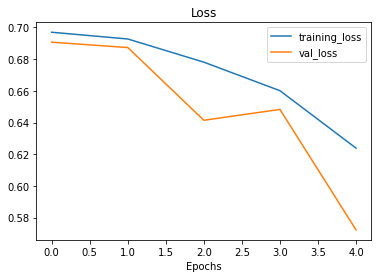

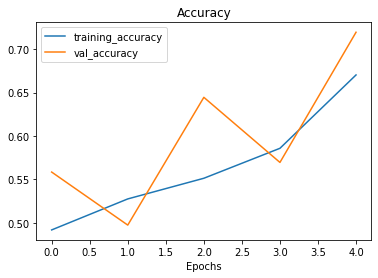

In [47]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

In [48]:
# Create a CNN model 8
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adamax(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=10,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs
                                                                         experiment_name="model 8")])

Saving TensorBoard log files to: tensorflow_hub_1/model 8/20230323-062723
Epoch 1/10
27/27 [==============================] - 30s 1s/step - loss: 0.6922 - accuracy: 0.5393 - val_loss: 0.6875 - val_accuracy: 0.4861
Epoch 2/10
27/27 [==============================] - 27s 1s/step - loss: 0.6846 - accuracy: 0.5690 - val_loss: 0.6759 - val_accuracy: 0.5722
Epoch 3/10
27/27 [==============================] - 27s 992ms/step - loss: 0.6875 - accuracy: 0.5381 - val_loss: 0.6742 - val_accuracy: 0.6306
Epoch 4/10
27/27 [==============================] - 30s 1s/step - loss: 0.6792 - accuracy: 0.5738 - val_loss: 0.6758 - val_accuracy: 0.5444
Epoch 5/10
27/27 [==============================] - 27s 1s/step - loss: 0.6799 - accuracy: 0.5607 - val_loss: 0.6894 - val_accuracy: 0.5111
Epoch 6/10
27/27 [==============================] - 27s 1s/step - loss: 0.6763 - accuracy: 0.5976 - val_loss: 0.6557 - val_accuracy: 0.6917
Epoch 7/10
27/27 [==============================] - 27s 991ms/step - loss: 0.6548 -

In [65]:
len(train_data_augmented_shuffled), len(test_data)

(27, 12)

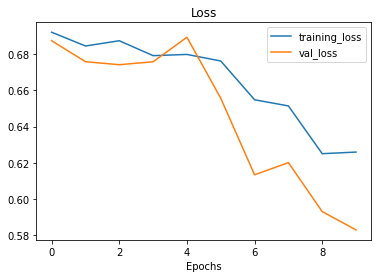

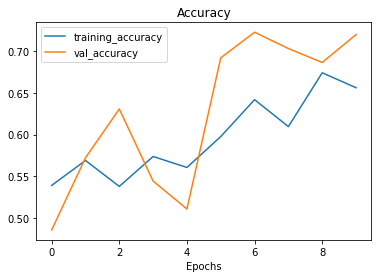

In [49]:
# Check model's performance history training on augmented data
plot_loss_curves(history_8)

### Try Pre-trained model(transfer learning) beacause we still get 62% accuracy on our model 8

In [50]:
# Setup data inputs

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setup the train and test directories
train_dir = "plastic_and_metal_bottles/Train_data/"
test_dir = "plastic_and_metal_bottles/Test_data/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_tf = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data_tf = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 840 images belonging to 2 classes.
Testing images:
Found 360 images belonging to 2 classes.


In [ ]:
train_data_tf.image_shape, test_data_tf.image_shape

((224, 224, 3), (224, 224, 3))

## Download pre-trained model

In [51]:
# this url is for download pretrained model from tensorflow_hub

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [52]:
# Function to make model
def create_model(model_url, num_classes=2):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [53]:
# Create model
resnet_model = create_model(resnet_url, num_classes= 1)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [68]:
# Fit the model
resnet_history = resnet_model.fit(train_data_augmented_shuffled,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_tf),
                                  validation_data=test_data_tf,
                                  validation_steps=len(test_data_tf),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", # save experiment logs
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub_1/resnet50V2/20230323-070258
Epoch 1/5
27/27 [==============================] - 29s 1s/step - loss: 0.2436 - accuracy: 0.9012 - val_loss: 0.4803 - val_accuracy: 0.8111
Epoch 2/5
27/27 [==============================] - 28s 1s/step - loss: 0.2144 - accuracy: 0.9155 - val_loss: 0.4302 - val_accuracy: 0.8361
Epoch 3/5
27/27 [==============================] - 31s 1s/step - loss: 0.1992 - accuracy: 0.9274 - val_loss: 0.4369 - val_accuracy: 0.8361
Epoch 4/5
27/27 [==============================] - 28s 1s/step - loss: 0.2010 - accuracy: 0.9214 - val_loss: 0.4514 - val_accuracy: 0.8278
Epoch 5/5
27/27 [==============================] - 28s 1s/step - loss: 0.1917 - accuracy: 0.9190 - val_loss: 0.4294 - val_accuracy: 0.8500


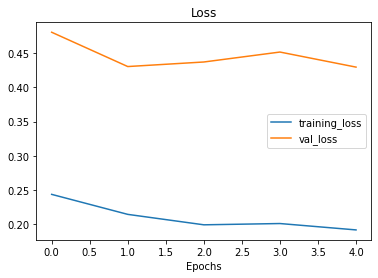

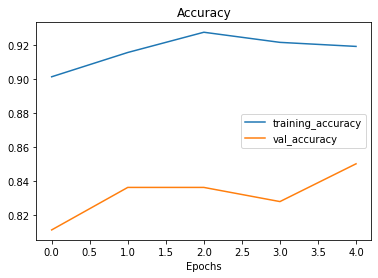

In [69]:
plot_loss_curves(resnet_history)

## Create efficientnet_model

In [62]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=1)

# Compile EfficientNet model
efficientnet_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00102),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_augmented_shuffled,
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_augmented_shuffled),
                                              validation_data=test_data_tf,
                                              validation_steps=len(test_data_tf),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub_1", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0_1")])

Saving TensorBoard log files to: tensorflow_hub_1/efficientnetB0_1/20230323-065316
Epoch 1/5
27/27 [==============================] - 41s 1s/step - loss: 0.5767 - accuracy: 0.6964 - val_loss: 0.4901 - val_accuracy: 0.7583
Epoch 2/5
27/27 [==============================] - 28s 1s/step - loss: 0.4054 - accuracy: 0.8536 - val_loss: 0.4273 - val_accuracy: 0.8056
Epoch 3/5
27/27 [==============================] - 27s 1s/step - loss: 0.3478 - accuracy: 0.8595 - val_loss: 0.4002 - val_accuracy: 0.8361
Epoch 4/5
27/27 [==============================] - 27s 1s/step - loss: 0.3072 - accuracy: 0.8833 - val_loss: 0.3867 - val_accuracy: 0.8417
Epoch 5/5
27/27 [==============================] - 27s 1s/step - loss: 0.2883 - accuracy: 0.8810 - val_loss: 0.3787 - val_accuracy: 0.8472


In [63]:
len(train_data_augmented_shuffled), len(test_data_tf)

(27, 12)

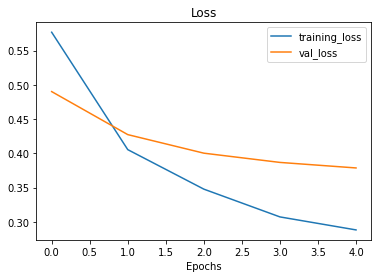

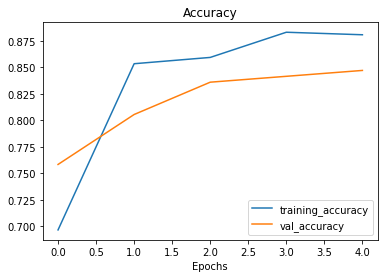

In [64]:
plot_loss_curves(efficientnet_history)

In [70]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img    

In [71]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 47ms/step


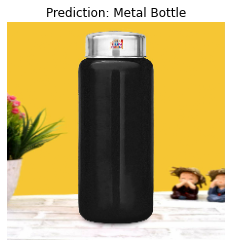

In [82]:
# Test our model on a custom image
pred_and_plot(efficientnet_model, "metal_bottle_7.jpg", class_names)